# CMPE462 - Assignment 1

## 2. Logistic Regression

### Importing the Data

In [1]:
from scipy.io import arff
import pandas as pd
import numpy as np

data, meta = arff.loadarff('Rice_Cammeo_Osmancik.arff')

df = pd.DataFrame(data)

df.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231.0,525.578979,229.749878,85.093788,0.928882,15617.0,0.572896,b'Cammeo'
1,14656.0,494.311005,206.020065,91.730972,0.895405,15072.0,0.615436,b'Cammeo'
2,14634.0,501.122009,214.106781,87.768288,0.912118,14954.0,0.693259,b'Cammeo'
3,13176.0,458.342987,193.337387,87.448395,0.891861,13368.0,0.640669,b'Cammeo'
4,14688.0,507.166992,211.743378,89.312454,0.906691,15262.0,0.646024,b'Cammeo'


#### Information about the data

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3810 entries, 0 to 3809
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Area               3810 non-null   float64
 1   Perimeter          3810 non-null   float64
 2   Major_Axis_Length  3810 non-null   float64
 3   Minor_Axis_Length  3810 non-null   float64
 4   Eccentricity       3810 non-null   float64
 5   Convex_Area        3810 non-null   float64
 6   Extent             3810 non-null   float64
 7   Class              3810 non-null   object 
dtypes: float64(7), object(1)
memory usage: 238.3+ KB


In [3]:
df.max()

Area                     18913.0
Perimeter             548.445984
Major_Axis_Length     239.010498
Minor_Axis_Length      107.54245
Eccentricity            0.948007
Convex_Area              19099.0
Extent                   0.86105
Class                b'Osmancik'
dtype: object

In [4]:
df.min()

Area                     7551.0
Perimeter            359.100006
Major_Axis_Length    145.264465
Minor_Axis_Length     59.532406
Eccentricity           0.777233
Convex_Area              7723.0
Extent                 0.497413
Class                 b'Cammeo'
dtype: object

### Normalizing Data

#### Considering the nature of the data we should not normalize the ones that are already between 0 and 1 

In [5]:
def normalize_chosen_data(df, target_column, exclude_columns=[]):
    normalized_df = df.copy()
    for column in df.columns:
        if column != target_column and column not in exclude_columns:
            max_value = df[column].max()
            min_value = df[column].min()
            normalized_df[column] = (df[column] - min_value) / (max_value - min_value)
    return normalized_df

target_column_name = 'Class'
exclude_columns = ['Eccentricity', 'Extent']
normalized_df = normalize_chosen_data(df, target_column_name, exclude_columns)

normalized_df.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,0.675937,0.879232,0.901216,0.532417,0.928882,0.693917,0.572896,b'Cammeo'
1,0.625330,0.714095,0.648087,0.670663,0.895405,0.646009,0.615436,b'Cammeo'
2,0.623394,0.750066,0.734349,0.588124,0.912118,0.635636,0.693259,b'Cammeo'
3,0.495071,0.524136,0.512800,0.581461,0.891861,0.496220,0.640669,b'Cammeo'
4,0.628146,0.781992,0.709138,0.620288,0.906691,0.662711,0.646024,b'Cammeo'


In [6]:
normalized_df['Class'] = normalized_df['Class'].apply(lambda x: 1 if x == b'Cammeo' else 0).values
normalized_df.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,0.675937,0.879232,0.901216,0.532417,0.928882,0.693917,0.572896,1
1,0.625330,0.714095,0.648087,0.670663,0.895405,0.646009,0.615436,1
2,0.623394,0.750066,0.734349,0.588124,0.912118,0.635636,0.693259,1
3,0.495071,0.524136,0.512800,0.581461,0.891861,0.496220,0.640669,1
4,0.628146,0.781992,0.709138,0.620288,0.906691,0.662711,0.646024,1


### Model

#### Splitting train and test sets

In [7]:
def train_test_split(X, y, test_size=0.3, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    m = X.shape[0]
    
    indices = np.arange(m)
    np.random.shuffle(indices)
    
    test_samples = int(test_size * m)
    
    test_indices = indices[:test_samples]
    train_indices = indices[test_samples:]
    
    # split the data based on the indices
    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]
    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]
    
    return X_train, X_test, y_train, y_test

X = normalized_df[['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent']]
y = normalized_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Train set shape:", X_train.shape, "Labels:", y_train.shape)
print("Test set shape:", X_test.shape, "Labels:", y_test.shape)


Train set shape: (2667, 7) Labels: (2667,)
Test set shape: (1143, 7) Labels: (1143,)


#### Sigmoid and Compute Gradient Functions

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def computeGradient(X, y, y_pred):
    return np.dot(X.T, (y_pred - y)) / y.shape[0]

#### Logistic Regression trained with GD

In [9]:
def logistic_regression_GD(X, y, lr=0.1, iterations=1000):
    w = np.zeros(X.shape[1]) 
    losses = []

    for i in range(iterations):
        y_pred = sigmoid(np.dot(X, w))  
        gradient = computeGradient(X, y, y_pred)  
        w -= lr * gradient
        
        # calculate loss
        epsilon = 1e-5  # adding a small constant to prevent log0
        loss = -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
        losses.append(loss)

    return w, losses

weights, losses = logistic_regression_GD(X_train, y_train, lr=0.1, iterations=1000)

print("Weights:", weights)

Weights: [ 1.54534364  2.50251218  2.8265987  -0.91141588 -2.57004891  1.61442835
 -2.29311512]


#### Logistic Regression trained with SGD

In [10]:
def logistic_regression_SGD(X, y, lr=0.01, iterations=1000):
    m = X.shape[0]
    w = np.zeros(X.shape[1])
    losses = []
    
    for i in range(iterations):
        epoch_loss = 0.0
        
        permutation = np.random.permutation(m)
        X_shuffled = X.values[permutation]
        y_shuffled = y.values[permutation]
        
        for j in range(m):
            # picking a random sample
            X_sample = X_shuffled[j]
            y_sample = y_shuffled[j]
            
            # calculate predicted value and gradient
            y_pred = sigmoid(np.dot(X_sample, w))
            gradient = np.dot(X_sample.T, (y_pred - y_sample))
            
            # calculate loss
            epsilon = 1e-15
            loss = - (y_sample * np.log(y_pred + epsilon) + (1 - y_sample) * np.log(1 - y_pred + epsilon))
            epoch_loss += loss
            
            # update weights
            w -= lr * gradient
            
        losses.append(epoch_loss / m)
    
    return w, losses

weights, losses = logistic_regression_SGD(X_train, y_train, iterations=1000)
print("Weights:", weights)

Weights: [  3.2735429    8.37157294  12.90151663 -10.76192317 -11.75929988
   6.59076163   1.31169506]


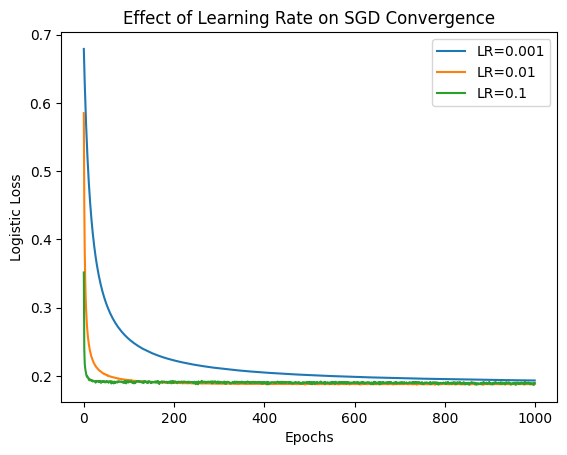

In [11]:
import matplotlib.pyplot as plt

# training with different learning rates
rates = [0.001, 0.01, 0.1]
losses_dict = {}

for rate in rates:
    w, losses = logistic_regression_SGD(X_train, y_train, lr=rate, iterations=1000)
    losses_dict[rate] = losses

for rate, losses in losses_dict.items():
    plt.plot(losses, label=f'LR={rate}')

plt.xlabel('Epochs')
plt.ylabel('Logistic Loss')
plt.title('Effect of Learning Rate on SGD Convergence')
plt.legend()
plt.show()

#### Logistic Regression Regularized by the Square of the Weight Vector’s l_2 norm trained with GD

In [12]:
def computeRegularizingTerm(lambda_val, w, y):
    return lambda_val * w / y.shape[0]

def logistic_regression_L2_GD(X, y, lr=0.1, lambda_val=0.1, iterations=1000):
    w = np.zeros(X.shape[1])  
    losses = []

    for i in range(iterations):
        y_pred = sigmoid(np.dot(X, w))  
        gradient = computeGradient(X, y, y_pred) + computeRegularizingTerm(lambda_val, w, y)
        w -= lr * gradient
        
        # calculate loss
        epsilon = 1e-5
        loss = -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))
        losses.append(loss)

    return w, losses

weights, losses = logistic_regression_L2_GD(X_train, y_train, iterations=1000)
print("Weights:", weights)

Weights: [ 1.5428142   2.49837157  2.8218779  -0.90985302 -2.56591294  1.61178323
 -2.28945883]


#### Logistic Regression Regularized by the Square of the Weight Vector’s l_2 norm trained with SGD

In [13]:
def logistic_regression_L2_SGD(X, y, lr=0.01, lambda_val=0.1, iterations=1000):
    m = X.shape[0]
    w = np.zeros(X.shape[1])
    losses = []
    
    for i in range(iterations):
        epoch_loss = 0.0

        permutation = np.random.permutation(m)
        X_shuffled = X.values[permutation]
        y_shuffled = y.values[permutation]
        
        for j in range(m):
            X_sample = X_shuffled[j]
            y_sample = y_shuffled[j]
            
            # calculate predicted value and gradient
            y_pred = sigmoid(np.dot(X_sample, w))
            gradient = (np.dot(X_sample.T, (y_pred - y_sample)) + lambda_val * w)
            
            # calculate loss
            epsilon = 1e-15
            loss = - (y_sample * np.log(y_pred + epsilon) + (1 - y_sample) * np.log(1 - y_pred + epsilon))
            epoch_loss += loss
            
            # update weights
            w -= lr * gradient
        losses.append(epoch_loss / m)
    
    return w, losses

weights, losses = logistic_regression_L2_SGD(X_train, y_train, iterations=1000)
print("Weights:", weights)

Weights: [ 0.23539844  0.3721388   0.41147436 -0.13020104 -0.42510944  0.24492295
 -0.38618361]


In [14]:
def predict(X, w):
    y_pred_proba = sigmoid(np.dot(X, w))
    y_pred = []
    for prob in y_pred_proba:
        if prob >= 0.5:
            y_pred.append(1)
        else:
            y_pred.append(0)
    y_pred = np.array(y_pred)
    return y_pred


X_test = pd.DataFrame(X_test)
y_pred = predict(X_test, weights)
X_train = pd.DataFrame(X_train)
y_pred_train = predict(X_train, weights)

# calculate accuracy
accuracy_test = np.mean(y_pred == y_test)
print("Test Accuracy:", accuracy_test)
accuracy_train = np.mean(y_pred_train == y_train)
print("Train Accuracy:", accuracy_train)

Test Accuracy: 0.8818897637795275
Train Accuracy: 0.8781402324709411


### 5-Fold Cross Validation

In [15]:
def cross_validate(X, y, learning_rate, lambda_vals, num_iterations, k=5):
    np.random.seed(42)
    lambda_performance = {}

    # shuffling
    indices = list(range(len(X)))  #list of indices
    np.random.shuffle(indices)
    X = X.iloc[indices]
    y = y.iloc[indices]
    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    # k-folds
    fold_size = len(X) // k

    for lambda_val in lambda_vals:
        accuracies = []

        for fold_num in range(k):
            val_start_index, val_end_index = fold_num * fold_size, (fold_num + 1) * fold_size
            X_val, y_val = X[val_start_index:val_end_index], y[val_start_index:val_end_index]
            X_train = pd.concat((X.iloc[:val_start_index], X.iloc[val_end_index:]), axis=0)
            y_train = pd.concat((y.iloc[:val_start_index], y.iloc[val_end_index:]), axis=0)
   
            # calculate accuracy on the test fold
            W, losses = logistic_regression_L2_SGD(X_train, y_train, lambda_val, learning_rate, num_iterations)
            y_pred = sigmoid(np.dot(X_test, W)) >= 0.5
            accuracy = np.mean(y_pred == y_test)
            accuracies.append(accuracy)
        
        # avg performance for this lambda
        lambda_performance[lambda_val] = np.mean(accuracies)

    best_lambda = max(lambda_performance, key=lambda_performance.get)
    return best_lambda, lambda_performance

lambda_vals = [0.001, 0.01, 0.1, 1]
best_lambda, performance = cross_validate(X, y, 0.01, lambda_vals, 1000)
print("Best lambda:", best_lambda)
print("Performance:", performance)


Best lambda: 0.01
Performance: {0.001: 0.9193350831146108, 0.01: 0.9195100612423447, 0.1: 0.9160104986876639, 1: 0.8218722659667541}


#### Plotting and Comparing the Loss Curves for SGD and GD

In [16]:
W_GD, loss_GD = logistic_regression_GD(X_train, y_train, lr=0.6)
W_SGD, loss_SGD = logistic_regression_SGD(X_train, y_train, lr=0.0001)

X_test = pd.DataFrame(X_test)
y_GD_pred = predict(X_test, W_GD)
y_SGD_pred = predict(X_test, W_SGD)

accuracy = np.mean(y_GD_pred == y_test)
print("Accuracy:", accuracy)
accuracy = np.mean(y_SGD_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9256342957130359
Accuracy: 0.9221347331583553


GD Training Time: 1.1876671314239502
SGD Training Time: 17.122313261032104


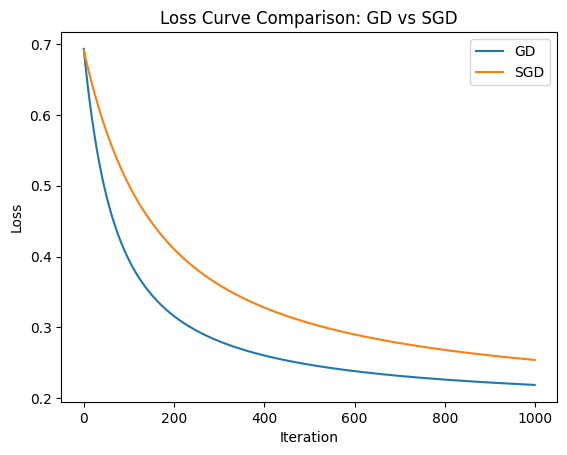

In [17]:
import matplotlib.pyplot as plt
import time

# GD
start_time = time.time()
weight_GD, losses_GD = logistic_regression_GD(X_train, y_train, lr=0.6)
end_time = time.time()
print("GD Training Time:", end_time - start_time)

# SGD
start_time = time.time()
weight_SGD, losses_SGD = logistic_regression_SGD(X_train, y_train, lr=0.0001)
end_time = time.time()
print("SGD Training Time:", end_time - start_time)

# plotting the loss curves
plt.plot(losses_GD, label='GD')
plt.plot(losses_SGD, label='SGD')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve Comparison: GD vs SGD')
plt.legend()
plt.show()

In [18]:
# finding similar models in terms of performance
W_L2_GD, loss_L2_GD = logistic_regression_L2_GD(X_train, y_train, lr=0.6, lambda_val= 0.5, iterations=2000)
W_L2_SGD, loss_L2_SGD = logistic_regression_L2_SGD(X_train, y_train, lr=0.0001, lambda_val = 0.01, iterations=2000)

X_test = pd.DataFrame(X_test)
y_GD_pred = predict(X_test, W_L2_GD)
y_SGD_pred = predict(X_test, W_L2_SGD)

accuracy = np.mean(y_GD_pred == y_test)
print("Accuracy:", accuracy)
accuracy = np.mean(y_SGD_pred == y_test)
print("Accuracy:", accuracy)

Accuracy: 0.9256342957130359
Accuracy: 0.9186351706036745


GD Training Time: 2.7310678958892822
SGD Training Time: 39.6856107711792


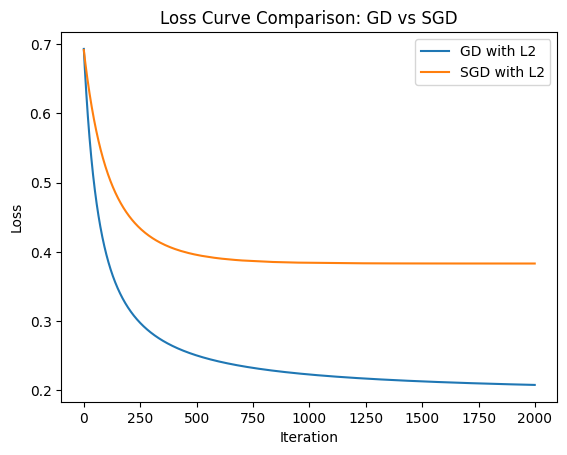

In [19]:
# GD
start_time = time.time()
weight_L2_GD, losses_L2_GD = logistic_regression_L2_GD(X_train, y_train, lr=0.6, lambda_val= 0.5, iterations=2000)
end_time = time.time()
print("GD Training Time:", end_time - start_time)

# SGD
start_time = time.time()
weight_L2_SGD, losses_L2_SGD = logistic_regression_L2_SGD(X_train, y_train, lr=0.0001, lambda_val = 0.01, iterations=2000)
end_time = time.time()
print("SGD Training Time:", end_time - start_time)

# plotting the loss curves
plt.plot(losses_L2_GD, label='GD with L2')
plt.plot(losses_L2_SGD, label='SGD with L2')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve Comparison: GD vs SGD')
plt.legend()
plt.show()